## Description:
建立Deep&Cross Model在cretio数据集上进行点击率预测的任务

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime

import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#from torchkeras import summary, Model

from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

## 数据准备

In [3]:
file_path = './preprocessed_data/'

In [4]:
def prepared_data(file_path):
    
    # 读入训练集，验证集和测试集
    train = pd.read_csv(file_path + 'train_set.csv')
    val = pd.read_csv(file_path + 'val_set.csv')
    test = pd.read_csv(file_path + 'test_set.csv')
    
    trn_x, trn_y = train.drop(columns='Label').values, train['Label'].values
    val_x, val_y = val.drop(columns='Label').values, val['Label'].values
    test_x = test.values
    
    fea_col = np.load(file_path + 'fea_col.npy', allow_pickle=True)
    
    return fea_col, (trn_x, trn_y), (val_x, val_y), test_x

In [5]:
fea_cols, (trn_x, trn_y), (val_x, val_y), test_x = prepared_data(file_path)

In [6]:
# 把数据构建成数据管道
dl_train_dataset = TensorDataset(torch.tensor(trn_x).float(), torch.tensor(trn_y).float())
dl_val_dataset = TensorDataset(torch.tensor(val_x).float(), torch.tensor(val_y).float())

dl_train = DataLoader(dl_train_dataset, shuffle=True, batch_size=32)
dl_val = DataLoader(dl_val_dataset, shuffle=True, batch_size=32)

In [7]:
# 看一下数据
for b in iter(dl_train):
    print(b[0].shape, b[1])
    break

torch.Size([32, 39]) tensor([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


## 构建模型
这里依然是使用继承nn.Module基类构建模型， 并辅助应用模型容器进行封装， Deep&Cross的模型结构如下：

![](img/deep&Cross.png)

这个模型W&D的基础上， 保持了Deep部分不变， 把Wide部分换成了Cross network的形式， 所以这里的关键部分是实现CrossNetwork， 也就是那个交叉公式。

In [8]:
class CrossNetwork(nn.Module):
    """
    Cross Network
    """
    def __init__(self, layer_num, input_dim):
        super(CrossNetwork, self).__init__()
        self.layer_num = layer_num
        
        # 定义网络层的参数
        self.cross_weights = nn.ParameterList([
            nn.Parameter(torch.rand(input_dim, 1))
            for i in range(self.layer_num)
        ])
        self.cross_bias = nn.ParameterList([
            nn.Parameter(torch.rand(input_dim, 1))
            for i in range(self.layer_num)
        ])
    
    def forward(self, x):
        # x是(None, dim)的形状， 先扩展一个维度到(None, dim, 1)
        x_0 = torch.unsqueeze(x, dim=2)
        x = x_0.clone()
        xT = x_0.clone().permute((0, 2, 1))     # （None, 1, dim)
        for i in range(self.layer_num):
            x = torch.matmul(torch.bmm(x_0, xT), self.cross_weights[i]) + self.cross_bias[i] + x   # (None, dim, 1)
            xT = x.clone().permute((0, 2, 1))   # (None, 1, dim)
        
        x = torch.squeeze(x)  # (None, dim)
        return x

In [9]:
class Dnn(nn.Module):
    """
    Dnn part
    """
    def __init__(self, hidden_units, dropout=0.):
        """
        hidden_units: 列表， 每个元素表示每一层的神经单元个数， 比如[256, 128, 64], 两层网络， 第一层神经单元128， 第二层64， 第一个维度是输入维度
        dropout: 失活率
        """
        super(Dnn, self).__init__()
        
        self.dnn_network = nn.ModuleList([nn.Linear(layer[0], layer[1]) for layer in list(zip(hidden_units[:-1], hidden_units[1:]))])
        #得到（256，128），（128，64）
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x):
        
        for linear in self.dnn_network:
            x = linear(x)
            x = F.relu(x)
        
        x = self.dropout(x)
        return x

In [12]:
class DCN(nn.Module):
    def __init__(self, feature_columns, hidden_units, layer_num, dnn_dropout=0.):
        super(DCN, self).__init__()
        self.dense_feature_cols, self.sparse_feature_cols = feature_columns
        # feature_columns是一个list，内部元素为两个list，分别记录dense_feat和sparse_feat,这两个list内部元素是字典
        
        
        # embedding 
        self.embed_layers = nn.ModuleDict({
            'embed_' + str(i): nn.Embedding(num_embeddings=feat['feat_num'], embedding_dim=feat['embed_dim'])
            for i, feat in enumerate(self.sparse_feature_cols)
        })
        
        hidden_units.insert(0, len(self.dense_feature_cols) + len(self.sparse_feature_cols)*self.sparse_feature_cols[0]['embed_dim'])
        self.dnn_network = Dnn(hidden_units)
        self.cross_network = CrossNetwork(layer_num, hidden_units[0])         # layer_num是交叉网络的层数， hidden_units[0]表示输入的整体维度大小
        self.final_linear = nn.Linear(hidden_units[-1]+hidden_units[0], 1)
    
    def forward(self, x):
        dense_input, sparse_inputs = x[:, :len(self.dense_feature_cols)], x[:, len(self.dense_feature_cols):]
        sparse_inputs = sparse_inputs.long()
        sparse_embeds = [self.embed_layers['embed_'+str(i)](sparse_inputs[:, i]) for i in range(sparse_inputs.shape[1])]
        sparse_embeds = torch.cat(sparse_embeds, axis=-1)
        
        x = torch.cat([sparse_embeds, dense_input], axis=-1)
        
        # cross Network
        cross_out = self.cross_network(x)
        
        # Deep Network
        deep_out = self.dnn_network(x)

        #  Concatenate
        total_x = torch.cat([cross_out, deep_out], axis=-1)
        
        # out
        outputs = F.sigmoid(self.final_linear(total_x))
        
        return outputs  

In [13]:
# 建立模型
hidden_units = [128, 64, 32]
dnn_dropout = 0.

model = DCN(fea_cols, hidden_units, len(hidden_units), dnn_dropout)
summary(model, input_shape=(trn_x.shape[1],))

--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Embedding-1                                  [-1, 8]                  632
Embedding-2                                  [-1, 8]                2,016
Embedding-3                                  [-1, 8]               10,344
Embedding-4                                  [-1, 8]                8,344
Embedding-5                                  [-1, 8]                  240
Embedding-6                                  [-1, 8]                   56
Embedding-7                                  [-1, 8]                9,312
Embedding-8                                  [-1, 8]                  312
Embedding-9                                  [-1, 8]                   16
Embedding-10                                 [-1, 8]                7,264
Embedding-11                                 [-1, 8]                7,408
Embedding-12                         

'--------------------------------------------------------------------------\nLayer (type)                            Output Shape              Param #\n==========================================================================\nEmbedding-1                                  [-1, 8]                  632\nEmbedding-2                                  [-1, 8]                2,016\nEmbedding-3                                  [-1, 8]               10,344\nEmbedding-4                                  [-1, 8]                8,344\nEmbedding-5                                  [-1, 8]                  240\nEmbedding-6                                  [-1, 8]                   56\nEmbedding-7                                  [-1, 8]                9,312\nEmbedding-8                                  [-1, 8]                  312\nEmbedding-9                                  [-1, 8]                   16\nEmbedding-10                                 [-1, 8]                7,264\nEmbedding-11          

In [14]:
# 测试一下模型
for fea, label in iter(dl_train):
    out = model(fea)
    print(out)
    break

tensor([[1.0000e+00],
        [0.0000e+00],
        [6.3098e-18],
        [6.0267e-26],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [6.2405e-02],
        [0.0000e+00],
        [0.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [8.2861e-30],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.9008e-28],
        [2.4690e-17],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [6.7005e-01],
        [0.0000e+00],
        [1.0000e+00],
        [1.0000e+00]], grad_fn=<SigmoidBackward>)


## 模型的训练

In [15]:
# 模型的相关设置
def auc(y_pred, y_true):
    pred = y_pred.data
    y = y_true.data
    return roc_auc_score(y, pred)

loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
metric_func = auc
metric_name = 'auc'

In [19]:
# 脚本训练风格
epochs = 100
log_step_freq = 10

dfhistory = pd.DataFrame(columns=['epoch', 'loss', metric_name, 'val_loss', 'val_'+metric_name])

print('start_training.........')
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('========'*8 + '%s' %nowtime)

for epoch in range(1, epochs+1):
    
    # 训练阶段
    model.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1
    
    for step, (features, labels) in enumerate(dl_train, 1):
        # 梯度清零
        optimizer.zero_grad()
        
        # 正向传播
        predictions = model(features);
        predictions = predictions.squeeze(-1)  #使得输出与标签的size一致 否则会报错
        loss = loss_func(predictions, labels)
        try:
            metric = metric_func(predictions, labels)
        except ValueError:
            pass
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step % log_step_freq == 0:
            print(("[step=%d] loss: %.3f, " + metric_name + ": %.3f") % (step, loss_sum/step, metric_sum/step));
    
    # 验证阶段
    model.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1
    
    for val_step, (features, labels) in enumerate(dl_val, 1):
        with torch.no_grad():
            predictions = model(features)
            predictions = predictions.squeeze(-1)  #使得输出与标签的size一致 否则会报错
            val_loss = loss_func(predictions, labels)
            try:
                val_metric = metric_func(predictions, labels)
            except ValueError:
                pass
        
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()
    
    # 记录日志
    info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info
    
    # 打印日志
    print(("\nEPOCH=%d, loss=%.3f, " + metric_name + " = %.3f, val_loss=%.3f, " + "val_" + metric_name + " = %.3f") %info)
    nowtime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print('\n' + '=========='* 8 + '%s' %nowtime)
    
print('Finished Training')

start_training.........
================================================================2022-10-17 10:06:35
[step=10] loss: 24.535, auc: 0.546
[step=20] loss: 24.841, auc: 0.543
[step=30] loss: 26.276, auc: 0.524
[step=40] loss: 26.069, auc: 0.541

EPOCH=1, loss=26.069, auc = 0.541, val_loss=27.193, val_auc = 0.505

================================================================================2022-10-17 10:06:37
[step=10] loss: 27.195, auc: 0.563
[step=20] loss: 26.593, auc: 0.556
[step=30] loss: 26.803, auc: 0.541
[step=40] loss: 26.074, auc: 0.552

EPOCH=2, loss=26.074, auc = 0.552, val_loss=27.196, val_auc = 0.504

================================================================================2022-10-17 10:06:38
[step=10] loss: 26.447, auc: 0.524
[step=20] loss: 26.244, auc: 0.537
[step=30] loss: 27.299, auc: 0.530
[step=40] loss: 26.068, auc: 0.540

EPOCH=3, loss=26.068, auc = 0.540, val_loss=27.197, val_auc = 0.505

==============================================================

[step=20] loss: 22.385, auc: 0.566
[step=30] loss: 19.819, auc: 0.583
[step=40] loss: 19.804, auc: 0.588

EPOCH=27, loss=19.804, auc = 0.588, val_loss=22.733, val_auc = 0.511

================================================================================2022-10-17 10:07:07
[step=10] loss: 16.563, auc: 0.624
[step=20] loss: 19.183, auc: 0.585
[step=30] loss: 19.872, auc: 0.567
[step=40] loss: 19.794, auc: 0.584

EPOCH=28, loss=19.794, auc = 0.584, val_loss=22.718, val_auc = 0.528

================================================================================2022-10-17 10:07:09
[step=10] loss: 20.938, auc: 0.574
[step=20] loss: 22.344, auc: 0.554
[step=30] loss: 21.062, auc: 0.580
[step=40] loss: 19.789, auc: 0.590

EPOCH=29, loss=19.789, auc = 0.590, val_loss=22.718, val_auc = 0.521

================================================================================2022-10-17 10:07:10
[step=10] loss: 19.375, auc: 0.576
[step=20] loss: 19.219, auc: 0.576
[step=30] loss: 19.733, auc: 0.5

[step=10] loss: 19.556, auc: 0.571
[step=20] loss: 18.684, auc: 0.580
[step=30] loss: 18.874, auc: 0.585
[step=40] loss: 19.798, auc: 0.590

EPOCH=54, loss=19.798, auc = 0.590, val_loss=22.718, val_auc = 0.505

================================================================================2022-10-17 10:07:40
[step=10] loss: 22.295, auc: 0.603
[step=20] loss: 21.124, auc: 0.583
[step=30] loss: 20.958, auc: 0.593
[step=40] loss: 19.793, auc: 0.589

EPOCH=55, loss=19.793, auc = 0.589, val_loss=22.718, val_auc = 0.507

================================================================================2022-10-17 10:07:41
[step=10] loss: 21.515, auc: 0.591
[step=20] loss: 20.914, auc: 0.574
[step=30] loss: 21.166, auc: 0.579
[step=40] loss: 19.788, auc: 0.585

EPOCH=56, loss=19.788, auc = 0.585, val_loss=22.718, val_auc = 0.516

================================================================================2022-10-17 10:07:42
[step=10] loss: 20.494, auc: 0.567
[step=20] loss: 20.223, auc: 0.5

[step=10] loss: 21.250, auc: 0.571
[step=20] loss: 20.588, auc: 0.559
[step=30] loss: 20.140, auc: 0.583
[step=40] loss: 19.803, auc: 0.585

EPOCH=81, loss=19.803, auc = 0.585, val_loss=22.715, val_auc = 0.517

================================================================================2022-10-17 10:08:12
[step=10] loss: 23.570, auc: 0.593
[step=20] loss: 21.748, auc: 0.584
[step=30] loss: 20.228, auc: 0.595
[step=40] loss: 19.785, auc: 0.591

EPOCH=82, loss=19.785, auc = 0.591, val_loss=22.715, val_auc = 0.506

================================================================================2022-10-17 10:08:13
[step=10] loss: 15.938, auc: 0.597
[step=20] loss: 18.504, auc: 0.593
[step=30] loss: 18.665, auc: 0.592
[step=40] loss: 19.800, auc: 0.585

EPOCH=83, loss=19.800, auc = 0.585, val_loss=22.715, val_auc = 0.521

================================================================================2022-10-17 10:08:14
[step=10] loss: 20.938, auc: 0.594
[step=20] loss: 19.688, auc: 0.5

In [20]:
dfhistory

,epoch,loss,auc,val_loss,val_auc
0,1.0,26.069467,0.541245,27.192516,0.504601
1,2.0,26.074197,0.552191,27.195511,0.503806
2,3.0,26.068056,0.540284,27.196565,0.505029
3,4.0,26.072208,0.546889,27.196650,0.512528
4,5.0,26.071530,0.534434,27.196223,0.518633
...,...,...,...,...,...
95,96.0,19.795181,0.588868,22.713974,0.545129
96,97.0,19.800212,0.587294,22.713833,0.523341
97,98.0,19.792632,0.592301,22.713709,0.528566
98,99.0,19.795140,0.591921,22.713601,0.515512


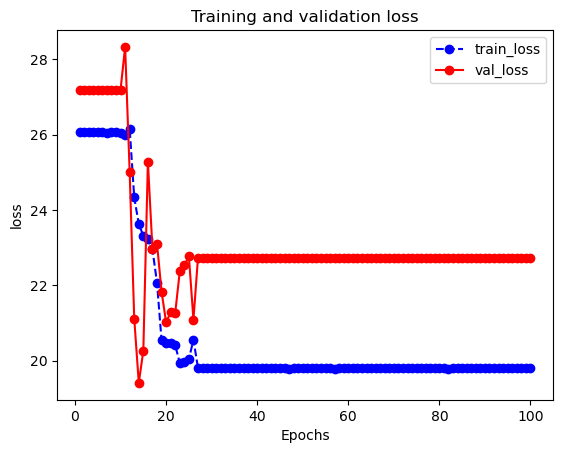

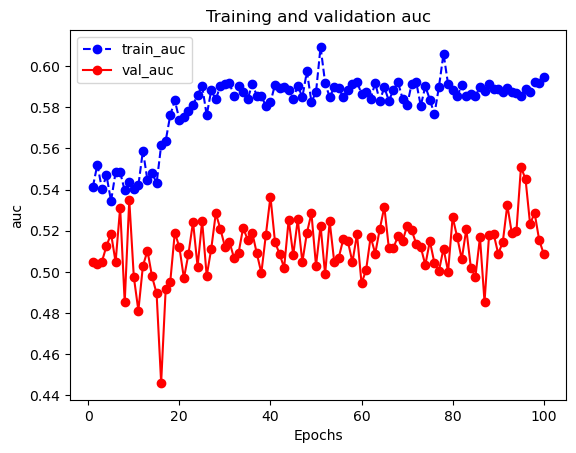

In [21]:
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


# 观察损失和准确率的变化
plot_metric(dfhistory,"loss")
plot_metric(dfhistory,"auc")

In [22]:
# 预测
y_pred_probs = model(torch.tensor(test_x).float())
y_pred = torch.where(y_pred_probs>0.5, torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))

In [23]:
y_pred.data

tensor([[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

In [24]:
# 模型的保存与使用
torch.save(model, './model/DCN.pkl') #这种保存方式同时存储模型结构和参数

In [25]:
net_clone = torch.load('./model/DCN.pkl')

In [26]:
y_pred_probs = net_clone(torch.tensor(test_x).float())
y_pred = torch.where(y_pred_probs>0.5, torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))

In [27]:
y_pred

tensor([[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      